# From LangyNet.ipynb

## Preliminary

In [ ]:
# Check gpu runtime
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)
    ram_gb = virtual_memory().total / 1e9
    print('\n')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
# Time code cell execution
!pip install ipython-autotime
%load_ext autotime

In [6]:
# Imports
from   google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   sklearn.model_selection import train_test_split
import sys
import time
import torch
import torch.nn as nn
from   torch.utils import data

time: 4.88 ms (started: 2021-05-01 00:16:46 +00:00)


In [7]:
# Plots
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
%matplotlib inline
plt.style.use('seaborn-darkgrid')

time: 4.03 ms (started: 2021-05-01 00:16:50 +00:00)


In [8]:
# Google Drive
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/')

Mounted at /content/gdrive
time: 24.2 s (started: 2021-05-01 00:16:52 +00:00)


## Data

In [9]:
def load_data(datapoints='max', random_state=None):
    """
    Load examples from a csv file and create a training and testing dataset using
    a standard 80/20 split.

    Parameters
    ----------
    datapoints : int or str, default='max'
        Number of examples to load from the csv.
    random_state : int or None, default=None
        Controls the shuffling of data before being split. Pass a specific int
        for a reproducible split.

    Returns
    -------
    train_dataset : TensorDataset
        Dataset containing 80% of randomly selected examples from the csv.
    test_dataset : TensorDataset
        Dataset containing the remaining 20% of examples.
    """

    # Get data as dataframe
    df = pd.read_csv('/content/gdrive/MyDrive/Uni/Year 3/ECS635U Project/model_input_duolingo_subset.csv')
    max_datapoints = len(df)

    # Optionally use a subset of data
    if datapoints != 'max':
        assert datapoints <= max_datapoints, f'max datapoints is {max_datapoints}'
        df = df[:datapoints]
    
    # Separate features and labels
    df_x = df.drop('p_trans', axis=1)
    df_y = df['p_trans'].to_frame()

    # Create feature and label tensors
    x = torch.tensor(df_x.values, dtype=torch.float32)
    y = torch.tensor(df_y.values, dtype=torch.float32)

    # Split data into testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2,
        random_state=random_state)

    # Create datasets
    train_dataset = data.TensorDataset(X_train, y_train)
    test_dataset = data.TensorDataset(X_test, y_test)

    return train_dataset, test_dataset

time: 16.1 ms (started: 2021-05-01 00:17:20 +00:00)


## Model

In [10]:
def init_weights(m):
    """Apply to a created model to initialise the weights and bias."""
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

time: 2.52 ms (started: 2021-05-01 00:17:26 +00:00)


In [11]:
class LangyBlock(nn.Module):
    """
    A block for a LangyNet model consisting of:
    - linear hidden layer
    - rectified linear activation function
    - dropout layer.

    Initialisation Parameters
    -------------------------
    id : int
        Block identification number.
    input_nodes : int
        Input size for the hidden layer.
    output_nodes : int
        Output size for the hidden layer i.e. number of hidden nodes.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Size([batch_size, input_nodes])

    Returns
    -------
    x : Tensor
        Size([batch_size, output_nodes])

    """

    def __init__(self, id, input_nodes, output_nodes, p_dropout=0):
        super(LangyBlock, self).__init__()
        self.id = id
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.p_dropout = p_dropout

        self.add_module(
            f'hid{self.id}',
            nn.Linear(self.input_nodes, self.output_nodes))
        self.add_module(
            f'act{self.id}',
            nn.ReLU())
        self.add_module(
            f'drop{self.id}',
            nn.Dropout(self.p_dropout))

    def forward(self, x):
        x = self._modules[f'hid{self.id}'](x)
        x = self._modules[f'act{self.id}'](x)
        x = self._modules[f'drop{self.id}'](x)
        return x

time: 23 ms (started: 2021-05-01 00:17:28 +00:00)


In [12]:
class LangyNet(nn.Module):
    """
    A Multilayer Perceptron with a configurable number of hidden layers.

    Takes a Tensor of learning traces and produces a prediction for the
    probability that the represented foreign word can be correctly translated.

    Initialisation Parameters
    -------------------------
    hidden_layers : int
        Number of hidden layers i.e. LangyBlocks to use.
    hidden_nodes : int
        Number of nodes to use in hidden layers.
    p_dropout : float, default=0
        Probability of a hidden layer node to be zeroed.

    Forward Parameters
    ------------------
    x : Tensor
        Tensor of learning traces, Size([batch_size, 10])

    Returns
    -------
    p_trans : Tensor
        Probability of correct translation, Size([batch_size, 1])
    """

    def __init__(self, hidden_layers, hidden_nodes, p_dropout=0):
        super(LangyNet, self).__init__()
        self.input_features = 10  # delta, seen, ..., frn_4
        self.output_features = 1  # p_trans
        self.hidden_layers = hidden_layers
        self.hidden_nodes = hidden_nodes
        self.p_dropout = p_dropout

        # Add hidden layers
        for i in range(hidden_layers):
            if i == 0:
                # First hidden layer
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.input_features, self.hidden_nodes, self.p_dropout))
            else:
                # Additional hidden layers
                self.add_module(
                    f'langy_block_{i+1}',
                    LangyBlock(i+1, self.hidden_nodes, self.hidden_nodes, self.p_dropout))
            
        # Output layer
        self.output = nn.Linear(self.hidden_nodes, self.output_features)
        

    def forward(self, x):
        for i in range(self.hidden_layers):
            x = self._modules[f'langy_block_{i+1}'](x)
        x = self.output(x)
        return x

time: 13.3 ms (started: 2021-05-01 00:17:30 +00:00)


## Training Functions

In [13]:
# https://d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#classification-accuracy

class Accumulator:
    """For accumulating sums over `n` variables."""
    
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

time: 5.91 ms (started: 2021-05-01 00:17:32 +00:00)


In [14]:
def train_epoch(model, device, train_loader, loss_fn, optimiser):
    """
    Trains a model for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    train_loader : DataLoader
        DataLoader which supplies examples from the training subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    optimiser : torch.optim.Optimizer
        Optimiser to update model parameters.
    
    Returns
    -------
    epoch_loss : float
        Loss of the model on training data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.train()  # training mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in train_loader:
        # CPU/GPU processing
        X, y = X.to(device), y.to(device)

        # Forward and backward pass
        optimiser.zero_grad()     # reset old gradients
        y_hat = model(X)          # compute prediction
        loss = loss_fn(y_hat, y)  # calculate loss
        loss.backward()           # calculate new gradients
        optimiser.step()          # update parameters

        # Statistics
        metric.add(
            float(loss.sum()),    # sum of training loss
            y.numel())            # number of examples

    return metric[0] / metric[1]  # training loss for epoch

time: 13.9 ms (started: 2021-05-01 00:17:32 +00:00)


In [15]:
def val_epoch(model, device, val_loader, loss_fn):
    """
    Performs model validation for a single epoch.

    Parameters
    ----------
    model : LangyNet
        The model to train.
    device : str
        For CPU/GPU processing, either 'cpu' or 'cuda:0'
    val_loader : DataLoader
        DataLoader which supplies examples from the validation subset.
    loss_fn : torch.nn Loss Function
        Loss function to measure error between predictions and ground truth.
    
    Returns
    -------
    val_loss : float
        Loss of the model on validation data after a single epoch.
    """

    if isinstance(model, torch.nn.Module):
        model.eval()  # evaluation mode

    metric = Accumulator(2)  # accumulate statistics over batches

    for X, y in val_loader:
        with torch.no_grad():
            # CPU/GPU processing
            X, y = X.to(device), y.to(device)

            # Computations
            y_hat = model(X)          # compute prediction
            loss = loss_fn(y_hat, y)  # calculate loss

            # Statistics
            metric.add(
                loss.cpu().numpy(),   # validation loss
                1)                    # validation steps
    
    return metric[0] / metric[1]

time: 9.83 ms (started: 2021-05-01 00:17:32 +00:00)


# Parameter Exploration

Train a variety of LangyNet models to compare the effect of different parameter configurations on loss.

Exploring the following parameters:
1. `hidden_nodes`: 8, 16, 32, 64, 80, 96
1. `hidden_layers`: 1, 2, 3
1. `p_dropout`: 0, 0.05, 0.1, 0.2
1. `weight_decay`: 0, 0.0001, 0.00025, 0.0005
1. `learning_rate`: 0.01, 0.001, 0.0005
1. `batch_size`: 16, 32, 64, 128

Consistent across models:
- `epochs: 200`
- trained using the same random subset of 20,000 examples

Note that a subset of examples is not necessarily representative of the complete dataset. A subset was used to decrease training time for comparative purposes. The optimal model is trained using all examples.

In [17]:
def explore(config, datapoints=20000, random_state=1, verbose=True):
    """
    A modification of the main training function.
    Create, train and validate a model over epochs.

    Parameters
    ----------
    config : dictionary
        Parameters each with a single value.
    datapoints : int or str, default=20000
        Number of examples to train with from the data csv file.
    random_state : int or None, default=1
        Controls the shuffling of data before being split for training and
        testing. Pass a specific int for a reproducible split.
    verbose : bool, default=True
        Control whether to print config and loss while training.
    
    Returns
    -------
    results : dict
        Keys: config, time, train_loss, val_loss
    """

    # Initialise model
    model = LangyNet(
        config['hidden_layers'],
        config['hidden_nodes'],
        config['p_dropout'])
    model.apply(init_weights)
    if verbose:
        print('='*50)
        print('config:', config)
        # print(model)

    # CPU/GPU processing
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # Split dataset for training and validation
    train_dataset, test_dataset = load_data(datapoints)
    train_size = int(len(train_dataset) * 0.8)  # 80%
    val_size = len(train_dataset) - train_size  # 20%
    train_subset, val_subset = data.random_split(
        train_dataset, [train_size, val_size])
    
    # Dataloaders
    train_loader = data.DataLoader(
        train_subset, config['batch_size'], shuffle=True)
    val_loader = data.DataLoader(
        val_subset, config['batch_size'], shuffle=True)

    # Loss and optimisation
    loss_fn = nn.MSELoss()
    optimiser = torch.optim.Adam(
        model.parameters(),
        weight_decay=config['weight_decay'],
        lr=config['learning_rate'])

    # Track results
    results = {
        'config': config,
        'time': 0,
        'train_loss': [],
        'val_loss': []
    }

    # Loop over dataset
    start_time = time.time()
    for epoch in range(config['epochs']):
        # Train and validate model
        train_loss = train_epoch(model, device, train_loader, loss_fn, optimiser)
        val_loss = val_epoch(model, device, val_loader, loss_fn)

        # Track statistics
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)

        # Display losses
        if verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
            print(f'ep {(epoch + 1)  :<3} ',
                f'train_loss={train_loss:.8f} ',
                f'val_loss={val_loss:.8f}')
    
    end_time = time.time()
    results['time'] = end_time - start_time
    print()

    return results

time: 41.9 ms (started: 2021-05-01 00:18:47 +00:00)


## Baseline Configuration

In [18]:
# Baseline configuration
config_base = {
    'hidden_layers': 1,
    'hidden_nodes': 16,
    'p_dropout': 0,
    'weight_decay': 0,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 200,
}

time: 1.5 ms (started: 2021-05-01 00:18:49 +00:00)


In [ ]:
results_base = explore(config_base)

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Baseline Configuration', fontsize=18)
plt.plot(results_base['train_loss'], label='training')
plt.plot(results_base['val_loss'], label='validation')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.ylim(0, 0.001)
plt.legend(
    title='loss',
    title_fontsize=16,
    fontsize=14,
    loc='upper right')
plt.show()

## Plotting Function

For explanation of spikes in loss, see 'Plot: Validation Loss' in the main notebook LangyNet.py

In [159]:
def plot_explored(parameter_name, results_list, y_metric='train_loss', y_max=0.001):
    """
    Plot exploration results against the baseline.

    Parameters
    ----------
    parameter_name : str
        Name of the parameter being explored.
    results_list : list of dict
        List of results produced by using explore() with other configurations.
    y_metric : str, default='train_loss'
        Metric to display on the y axis. Either 'train_loss' or 'val_loss'
    y_max : int, default=0.001
        Maximum value for the y axis.
    """

    plt.figure(figsize=(8, 6))
    plt.title(parameter_name, fontsize=18)

    # Plot baseline
    plt.plot(
        results_base[y_metric],
        label=results_base['config'][parameter_name],
        linestyle=':')  # easily distinguishable

    # Plot other results
    for result in results_list:
        plt.plot(
            result[y_metric],
            label=result['config'][parameter_name])

    plt.xlabel('epoch', fontsize=16)
    plt.ylabel(y_metric, fontsize=16)
    plt.ylim(0, y_max)

    plt.legend(
        title_fontsize=16,
        fontsize=14,
        loc='upper right')
    
    plt.show()

## hidden_layers

hidden_layers: 1, 2, 3

In [76]:
# config_hl_1 = config_base
config_hl_2 = config_base.copy(); config_hl_2['hidden_layers'] = 2
config_hl_3 = config_base.copy(); config_hl_3['hidden_layers'] = 3

In [ ]:
# results_hl_1 = results_base
results_hl_2 = explore(config_hl_2)
results_hl_3 = explore(config_hl_3)

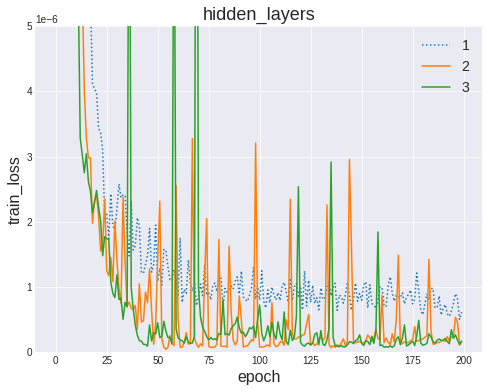

In [173]:
plot_explored(
    'hidden_layers',
    results_list=[
        results_hl_2,
        results_hl_3
    ],
    y_metric='train_loss',
    y_max=0.000005)

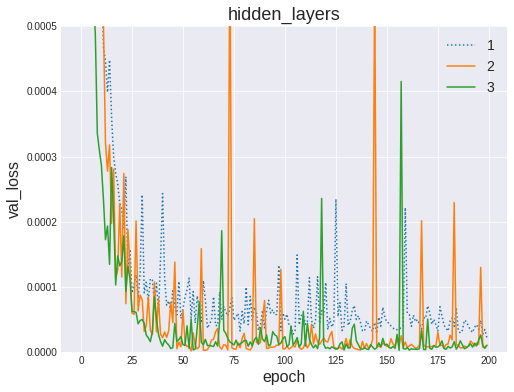

In [205]:
plot_explored(
    'hidden_layers',
    results_list=[
        results_hl_2,
        results_hl_3
    ],
    y_metric='val_loss',
    y_max=0.0005)

In [176]:
# Effect on training time for 20k examples
print(
    results_base['time'],  # 1
    results_hl_2['time'],
    results_hl_3['time'],
)

61.46473431587219 73.65367889404297 84.52225542068481


## hidden_nodes

hidden_nodes: 8, 16, 32, 64, 80, 96

In [92]:
# config_hn_16 = config_base
config_hn_8 = config_base.copy(); config_hn_8['hidden_nodes'] = 8
config_hn_32 = config_base.copy(); config_hn_32['hidden_nodes'] = 32
config_hn_64 = config_base.copy(); config_hn_64['hidden_nodes'] = 64
config_hn_80 = config_base.copy(); config_hn_80['hidden_nodes'] = 80
config_hn_96 = config_base.copy(); config_hn_96['hidden_nodes'] = 96

In [ ]:
# results_hn_16 = results_base
results_hn_8 = explore(config_hn_8)
results_hn_32 = explore(config_hn_32)
results_hn_64 = explore(config_hn_64)
results_hn_80 = explore(config_hn_80)
results_hn_96 = explore(config_hn_96)

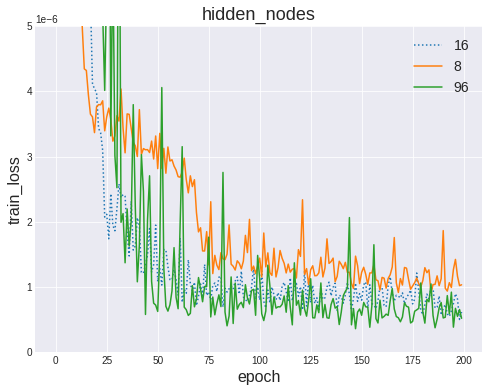

In [206]:
plot_explored(
    'hidden_nodes',
    results_list=[
        results_hn_8,
        results_hn_96
    ],
    y_metric='train_loss',
    y_max=0.000005)

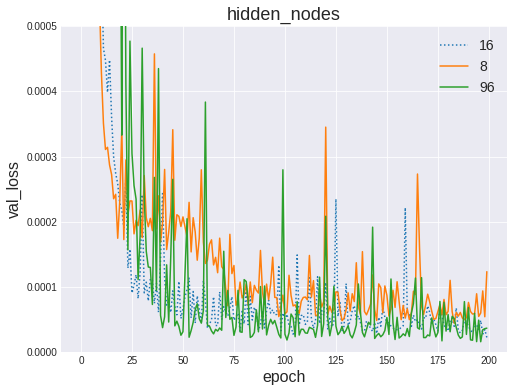

In [208]:
plot_explored(
    'hidden_nodes',
    results_list=[
        results_hn_8,
        results_hn_96
    ],
    y_metric='val_loss',
    y_max=0.0005)

## p_dropout

p_dropout: 0, 0.05, 0.1, 0.2

In [127]:
# config_drp_0 = config_base
config_drp_0_05 = config_base.copy(); config_drp_0_05['p_dropout'] = 0.05
config_drp_0_1 = config_base.copy(); config_drp_0_1['p_dropout'] = 0.1
config_drp_0_2 = config_base.copy(); config_drp_0_2['p_dropout'] = 0.2

In [ ]:
# results_drp_0 = results_base
results_drp_0_05 = explore(config_drp_0_05)
results_drp_0_1 = explore(config_drp_0_1)
results_drp_0_2 = explore(config_drp_0_2)

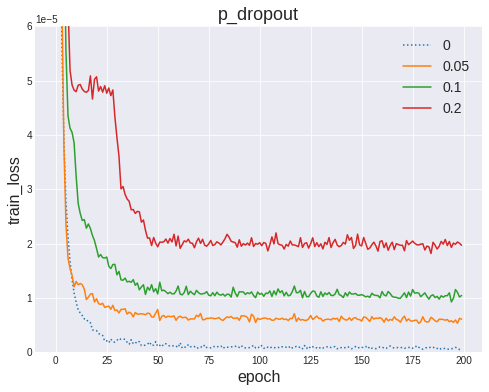

In [156]:
plot_explored(
    'p_dropout',
    results_list=[
        results_drp_0_05,
        results_drp_0_1,
        results_drp_0_2
    ],
    y_metric='train_loss',
    y_max=0.00006)

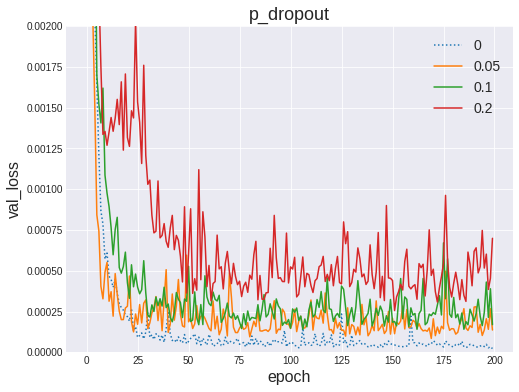

In [216]:
plot_explored(
    'p_dropout',
    results_list=[
        results_drp_0_05,
        results_drp_0_1,
        results_drp_0_2
    ],
    y_metric='val_loss',
    y_max=0.002)

## weight_decay

weight_decay: 0, 0.0001, 0.00025, 0.0005

In [131]:
# config_wd_0 = config_base
config_wd_0_0001 = config_base.copy(); config_wd_0_0001['weight_decay'] = 0.0001
config_wd_0_00025 = config_base.copy(); config_wd_0_00025['weight_decay'] = 0.00025
config_wd_0_0005 = config_base.copy(); config_wd_0_0005['weight_decay'] = 0.0005

In [ ]:
# results_wd_0 = results_base
results_wd_0_0001 = explore(config_wd_0_0001)
results_wd_0_00025 = explore(config_wd_0_00025)
results_wd_0_0005 = explore(config_wd_0_0005)

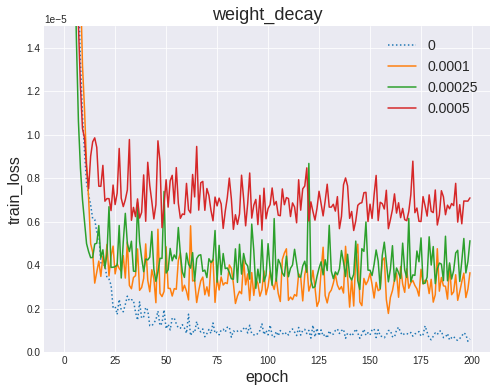

In [157]:
plot_explored(
    'weight_decay',
    results_list=[
        results_wd_0_0001,
        results_wd_0_00025,
        results_wd_0_0005
    ],
    y_metric='train_loss',
    y_max=0.000015)

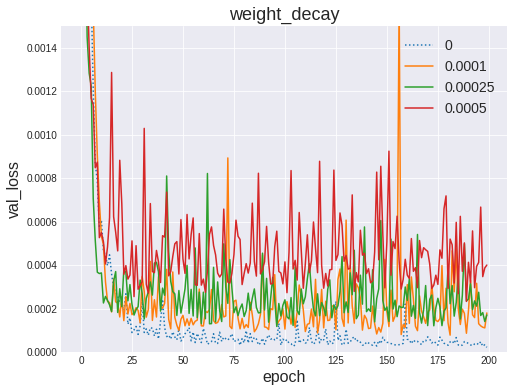

In [223]:
plot_explored(
    'weight_decay',
    results_list=[
        results_wd_0_0001,
        results_wd_0_00025,
        results_wd_0_0005
    ],
    y_metric='val_loss',
    y_max=0.0015)

## learning_rate

learning_rate: 0.01, 0.001, 0.0005

In [164]:
# config_lr_0_01 = config_base
config_lr_0_001 = config_base.copy(); config_lr_0_001['learning_rate'] = 0.001
config_lr_0_0005 = config_base.copy(); config_lr_0_0005['learning_rate'] = 0.0005

In [ ]:
# results_lr_0_01 = results_base
results_lr_0_001 = explore(config_lr_0_001)
results_lr_0_0005 = explore(config_lr_0_0005)

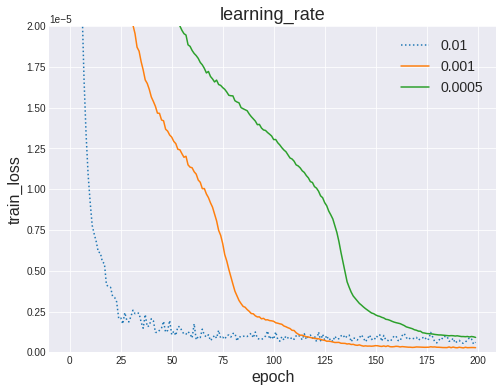

In [171]:
plot_explored(
    'learning_rate',
    results_list=[
        results_lr_0_001,
        results_lr_0_0005
    ],
    y_metric='train_loss',
    y_max=0.00002)

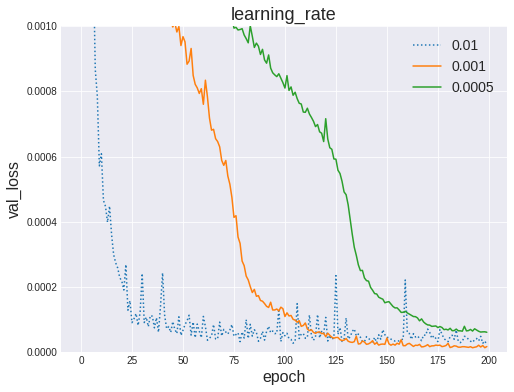

In [220]:
plot_explored(
    'learning_rate',
    results_list=[
        results_lr_0_001,
        results_lr_0_0005
    ],
    y_metric='val_loss',
    y_max=0.001)

## batch_size

batch_size: 16, 32, 64, 128

In [174]:
# config_bs_64 = config_base
config_bs_16 = config_base.copy(); config_bs_16['batch_size'] = 16
config_bs_32 = config_base.copy(); config_bs_32['batch_size'] = 32
config_bs_128 = config_base.copy(); config_bs_128['batch_size'] = 128

In [ ]:
# results_bs_64 = results_base
results_bs_16 = explore(config_bs_16)
results_bs_32 = explore(config_bs_32)
results_bs_128 = explore(config_bs_128)

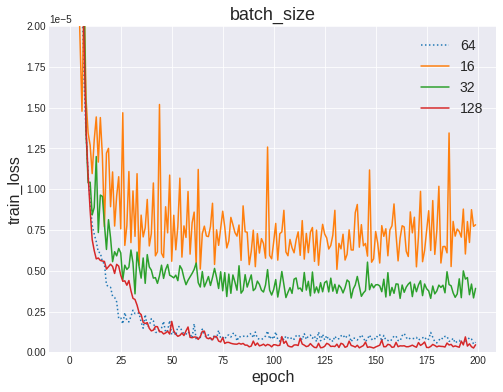

In [181]:
plot_explored(
    'batch_size',
    results_list=[
        results_bs_16,
        results_bs_32,
        results_bs_128
    ],
    y_metric='train_loss',
    y_max=0.00002)

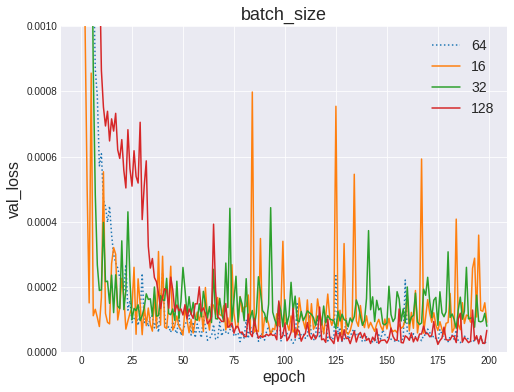

In [225]:
plot_explored(
    'batch_size',
    results_list=[
        results_bs_16,
        results_bs_32,
        results_bs_128
    ],
    y_metric='val_loss',
    y_max=0.001)

In [182]:
# Effect on training time for 20k examples
print(
    results_bs_16['time'],
    results_bs_32['time'],
    results_base['time'],  # 64
    results_bs_128['time'],
)

205.8159260749817 110.60713458061218 61.46473431587219 37.94998574256897


# Results Analysis

Decide what values to use in a grid search to find the optimal configuration.

##hidden_layers
- **search space: 2, 3**
- more layers causes a small increase in training time
- 2 and 3 achieve lower loss than 1
- 2 and 3 achieve similar loss
- both values will be searched

##hidden_nodes
- **search space: 16, 64, 96**
- lower value hidden_nodes=8 did not work as well and had the highest loss
- difference in loss for higher values is very similar; no significant difference
- will search with a range of values above 8

##p_dropout
- **fixed value: 0**
- p_dropout=0 clearly works best

##weight_decay
- **fixed value: 0**
- weight_decay=0 clearly works best

##learning_rate
- **fixed value: 0.001**
- tested values 0.01, 0.001, 0.0005 all manage to achieve similar loss after 200 epochs
- minimum loss seen using learning_rate=0.001 after about 120 epochs

##batch_size
- **fixed value: 128**
- doubling batch size nearly halves the training time
- loss for 64 and 128 is lower than 16 and 32
- 64 and 128 achieve very similar loss, they work equally well
- value of 128 results in the fastest training